<a href="https://colab.research.google.com/github/bhumiii2114/SVMParameterOptimization/blob/main/SVMParameterOptimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
data = fetch_ucirepo(id=864)

# data (as pandas dataframes)
X = data.data.features
y = data.data.targets

In [4]:
X.head()

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0


In [5]:
y.head()

,Room_Occupancy_Count
0,1
1,1
2,1
3,1
4,1


In [6]:
print(y.iloc[:, 0].unique())

[1 2 3 0]


In [7]:
print(X.shape)

(10129, 18)


Dataset has 10k+ instances

In [8]:
print("Missing values in X (features):")
print(X.isnull().sum())
print("\nMissing values in y (target):")
print(y.isnull().sum())

Missing values in X (features):
Date            0
Time            0
S1_Temp         0
S2_Temp         0
S3_Temp         0
S4_Temp         0
S1_Light        0
S2_Light        0
S3_Light        0
S4_Light        0
S1_Sound        0
S2_Sound        0
S3_Sound        0
S4_Sound        0
S5_CO2          0
S5_CO2_Slope    0
S6_PIR          0
S7_PIR          0
dtype: int64

Missing values in y (target):
Room_Occupancy_Count    0
dtype: int64


No missing values in dataset.

In [9]:
print(X.describe())

            S1_Temp       S2_Temp       S3_Temp       S4_Temp      S1_Light  \
count  10129.000000  10129.000000  10129.000000  10129.000000  10129.000000   
mean      25.454012     25.546059     25.056621     25.754125     25.445059   
std        0.351351      0.586325      0.427283      0.356434     51.011264   
min       24.940000     24.750000     24.440000     24.940000      0.000000   
25%       25.190000     25.190000     24.690000     25.440000      0.000000   
50%       25.380000     25.380000     24.940000     25.750000      0.000000   
75%       25.630000     25.630000     25.380000     26.000000     12.000000   
max       26.380000     29.000000     26.190000     26.560000    165.000000   

          S2_Light      S3_Light      S4_Light      S1_Sound      S2_Sound  \
count  10129.00000  10129.000000  10129.000000  10129.000000  10129.000000   
mean      26.01629     34.248494     13.220259      0.168178      0.120066   
std       67.30417     58.400744     19.602219      0.

Data needs to be normalised - especially for SVMs, which are sensitive to feature scales.

In [10]:
from sklearn.preprocessing import StandardScaler
X_df=X.drop(['Time','Date'],axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df)

10 test-train split samples.

In [11]:
# If y is a DataFrame, convert it to a 1D Series
y = y.iloc[:, 0]


In [12]:
from sklearn.model_selection import train_test_split

samples = []
for _ in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, stratify=y)
    samples.append((X_train, X_test, y_train, y_test))

In [13]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

# Parameter grid
param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

results = []
best_sample_curve = []
overall_best_acc = 0  # To track best overall sample

for i in range(10):
    print(f"\n🎯 Sample {i+1}")

    # 70-30 split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.3, stratify=y, random_state=i
    )

    # Grid search with 5-fold cross-validation
    grid = GridSearchCV(SVC(), param_grid, cv=5, n_jobs=-1)
    grid.fit(X_train, y_train)

    # Best estimator from grid search
    best_model = grid.best_estimator_

    # Test set accuracy
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    results.append({
        'Sample': f'S{i+1}',
        'Best Accuracy': round(acc, 4),
        'Kernel': grid.best_params_['kernel'],
        'C': grid.best_params_['C'],
        'Gamma': grid.best_params_['gamma']
    })

    # Save best sample's convergence (mean test score per param set)
    if acc > overall_best_acc:
        overall_best_acc = acc
        best_sample_curve = grid.cv_results_['mean_test_score']

# Final result table
results_df = pd.DataFrame(results)
print("\n📊 Results Table:\n", results_df)


🎯 Sample 1

🎯 Sample 2

🎯 Sample 3

🎯 Sample 4

🎯 Sample 5

🎯 Sample 6

🎯 Sample 7

🎯 Sample 8

🎯 Sample 9

🎯 Sample 10

📊 Results Table:
   Sample  Best Accuracy  Kernel   C  Gamma
0     S1         0.9977  linear   1  scale
1     S2         0.9947  linear   1  scale
2     S3         0.9974  linear  10  scale
3     S4         0.9944  linear   1  scale
4     S5         0.9941  linear   1  scale
5     S6         0.9957  linear   1  scale
6     S7         0.9951  linear   1  scale
7     S8         0.9951  linear  10  scale
8     S9         0.9967  linear  10  scale
9    S10         0.9961  linear  10  scale


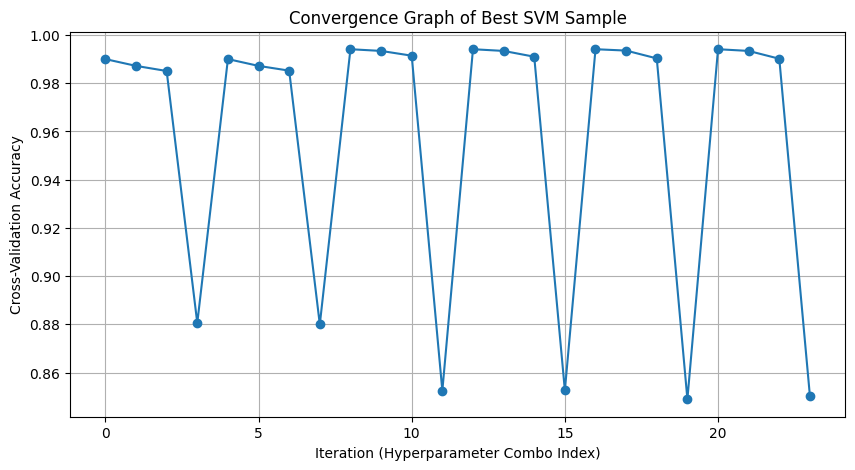

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(best_sample_curve, marker='o')
plt.title("Convergence Graph of Best SVM Sample")
plt.xlabel("Iteration (Hyperparameter Combo Index)")
plt.ylabel("Cross-Validation Accuracy")
plt.grid(True)
plt.savefig("convergence_s6.png")  # for ReadMe
plt.show()